# This lab will compare nonparametric spectral estimators such as periodogram and parametric estimator such as Capon and linear predictions for different type of signa (autoregressive and sum of sinusoids)

# 1.Autoregressive process

In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import welch,lfilter
from librosa import lpc

In [19]:
#1.1 Synthesis
sigma=1
ar_coeff=[0.9]     #We suppose a canonical representation
N=2000
def init_AR(sigma,ar_coeff,N):
    ''' Initiate an AR(p) process using ar_coeff as coefficient and compute the process using recursion formula'''
    X=np.random.normal(scale=sigma,size=N)
    for t in range(len(ar_coeff),N):
        X[t]+=ar_coeff@np.transpose([X[t-i] for i in range(1,len(ar_coeff)+1)])
    return X

x=init_AR(sigma,ar_coeff,N)

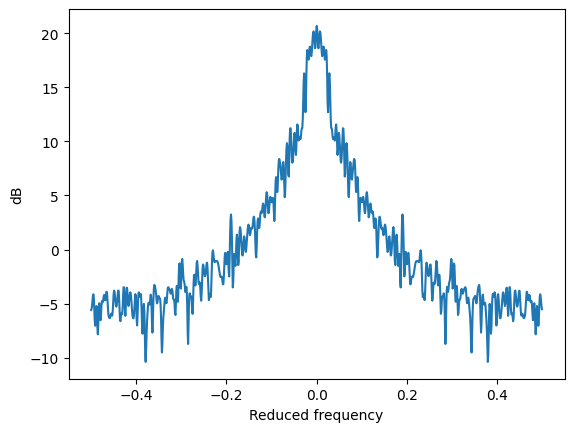

In [20]:
#1.2 Periodogram computation

def periodOgram(x,S_len,method='standart',L=1,overlap=None,toggle=True):       #L is a parameter for barlett and welsh method
    ''' Compute a periodogram estimator, specifying the method
        S_len is the length of the output periodogram
        L is a parameter for barlett and welsh method
        Toggle always the corresponding graphs to be shown'''
    N=len(x)
    nu=[i/S_len-1/2 for i in range(S_len)]
    if method=='standart':
        X=np.fft.fft(x,S_len)
        S=np.abs(np.fft.fft(x,S_len))**2/S_len
        S=10*np.log10(S)
        if toggle:
            plt.plot(nu,np.fft.fftshift(S))
            plt.xlabel('Reduced frequency')
            plt.ylabel('dB')
        return np.fft.fftshift(S)
    elif method=='bartlett':
        M = len(x) // L
        S = np.zeros(S_len)
        for segment in x.reshape(L,M):
            S += np.abs(np.fft.fft(segment,S_len))**2 /(len(x))
        S=10*np.log10(S)
        if toggle:
            plt.plot(nu,np.fft.fftshift(S))
            plt.xlabel('Reduced frequency')
            plt.ylabel('dB')
        return np.fft.fftshift(S)
    
    elif method=='welsh':
        S=welch(x,nfft=S_len,nperseg=len(x)//L,noverlap=overlap)[1][1:]
        S=np.concatenate((np.flip(S),S))
        S=10*np.log10(S)
        if toggle:
            plt.plot(nu,S)
            plt.xlabel('Reduced frequency')
            plt.ylabel('dB')
        return S
    else:
        print('Wrong method picked')
        return 

    
S=periodOgram(x,1000,method='bartlett',L=10)


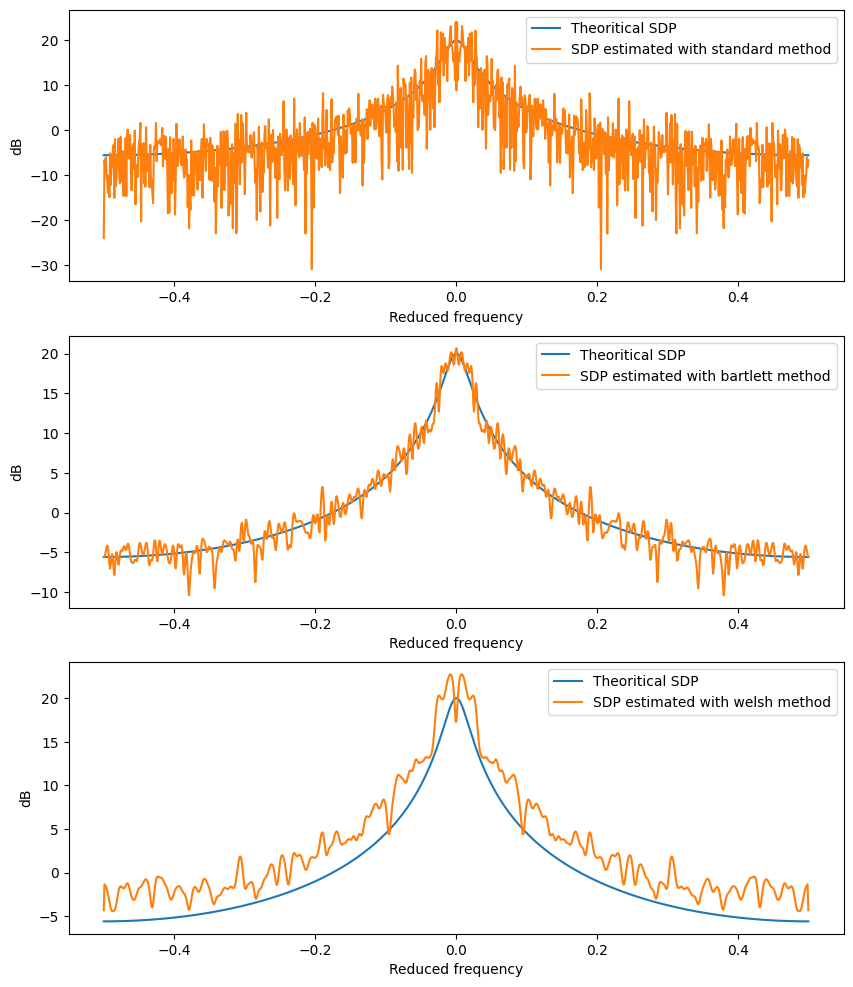

In [21]:
#1.3 Displaying periodogram
S_len=1000
nu=[i/S_len-1/2 for i in range(S_len)]
S_th=10*np.log10([sigma**2/np.abs(1-ar_coeff[0]*np.exp(2j*np.pi*v))**2 for v in nu])

plt.figure(figsize=(10, 12))
plt.subplot(3,1,1)
plt.plot(nu,S_th) 
plt.plot(nu,periodOgram(x,S_len,toggle=False))
plt.legend(['Theoritical SDP','SDP estimated with standard method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.subplot(3,1,2)
plt.plot(nu,S_th)
plt.plot(nu,periodOgram(x,S_len,method='bartlett',L=10,toggle=False))
plt.legend(['Theoritical SDP','SDP estimated with bartlett method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.subplot(3,1,3)
plt.plot(nu,S_th )
plt.plot(nu,periodOgram(x,S_len,method='welsh',L=10,overlap=50,toggle=False))
plt.legend(['Theoritical SDP','SDP estimated with welsh method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.show()

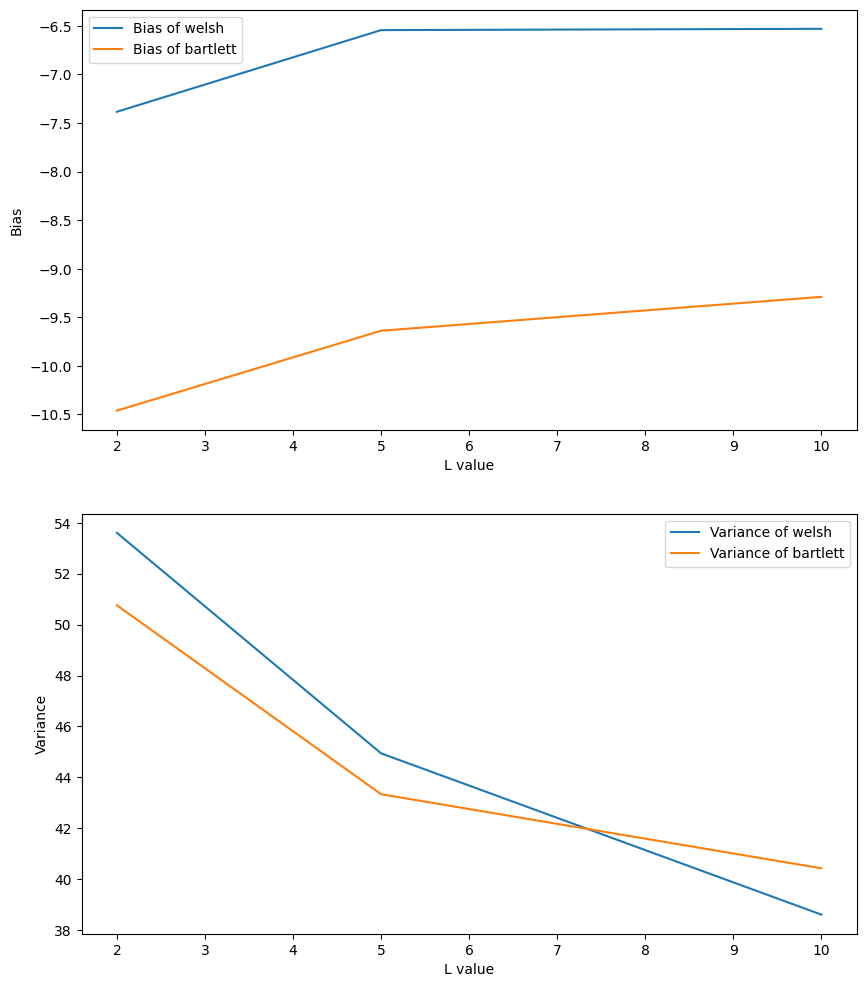

In [22]:
#1.4
S_th=10*np.log10([sigma**2/((1-2*ar_coeff[0]*np.cos(np.pi*v)+ar_coeff[0]**2)**2) for v in nu])
bias= {'welsh': [], 'bartlett': []}
variance= {'welsh': [], 'bartlett': []}
L_value=[2,5,10]
for L in L_value:
    for method in ['welsh','bartlett']:
        P=periodOgram(x,S_len,method=method,L=L,overlap=S_len//(L*3),toggle=False)
        bias[method].append(np.mean(P-S_th))
        variance[method].append(np.var(P-S_th))
plt.figure(figsize=(10, 12))
plt.subplot(2,1,1)
plt.plot(L_value,bias['welsh'])
plt.plot(L_value,bias['bartlett'])
plt.legend(['Bias of welsh','Bias of bartlett'])
plt.xlabel('L value')
plt.ylabel('Bias')
plt.subplot(2,1,2)
plt.plot(L_value,variance['welsh'])
plt.plot(L_value,variance['bartlett'])
plt.legend(['Variance of welsh','Variance of bartlett'])
plt.xlabel('L value')
plt.ylabel('Variance')
plt.show()

#Incresing L diminish the variance but increase the bias, a good balance need to be found.


In [23]:
#1.5
def estimate(x,order):
    ''' Estimate an AR(p) process of order order using linear forward prediction method'''
    a = lpc(x, order=order)
    print(a)
    b = np.hstack([[0], -1 * a[1:]])
    x_estimate = lfilter(b, [1], x)
    fig, ax = plt.subplots()
    ax.plot(x)
    ax.plot(x_estimate, linestyle='--')
    ax.legend(['x', 'x_estimate'])
    ax.set_title('LP Model Forward Prediction')
    ax.set_xlabel('sample')
    return x


[ 1.         -0.90633251]


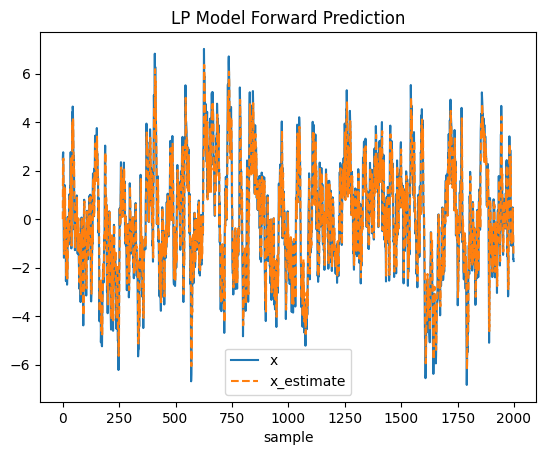

In [24]:
#1.6
x_estimate=estimate(x,1)

[ 1.         -0.91552052]


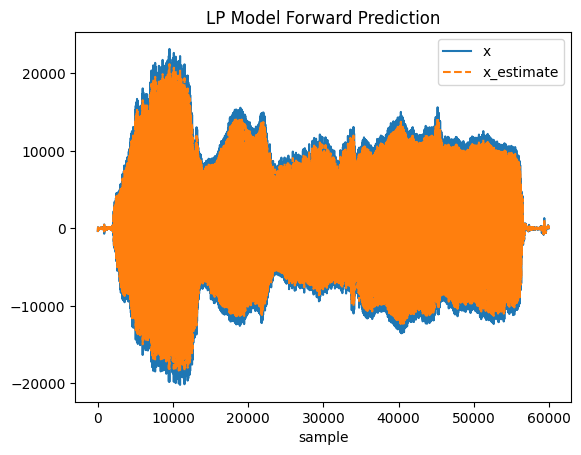

In [25]:
#1.7
from scipy.io import wavfile

data_path = os.getcwd()
filename = 'sounds/aeiou.wav'
sound = os.path.join(data_path, filename) 
sample_rate, wav_data = wavfile.read(sound)
sound_estimate=estimate(np.array(wav_data,dtype=float),order=1)

#It seems that this soundfile could be estimated as an AR(1) process

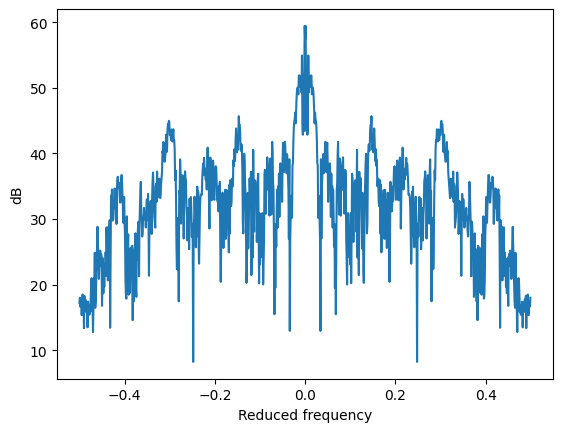

In [26]:
plt.plot(periodOgram(wav_data,1000)[1])

$$2.~~ Sum ~~of ~~noisy ~~sinusoids$$

In [27]:
#2.1
def sig_sin(freq,amp,phase,sigma,N):
    ''' Compute a signal consisting of a sum of sinus, using the formula given by question 2.1'''
    return np.array([np.sum(np.array([amp[k]*np.sin(freq[k]*i*2*np.pi+phase[k]) for k in range(len(freq))]))+np.random.normal(scale=sigma) for i in range(N)])

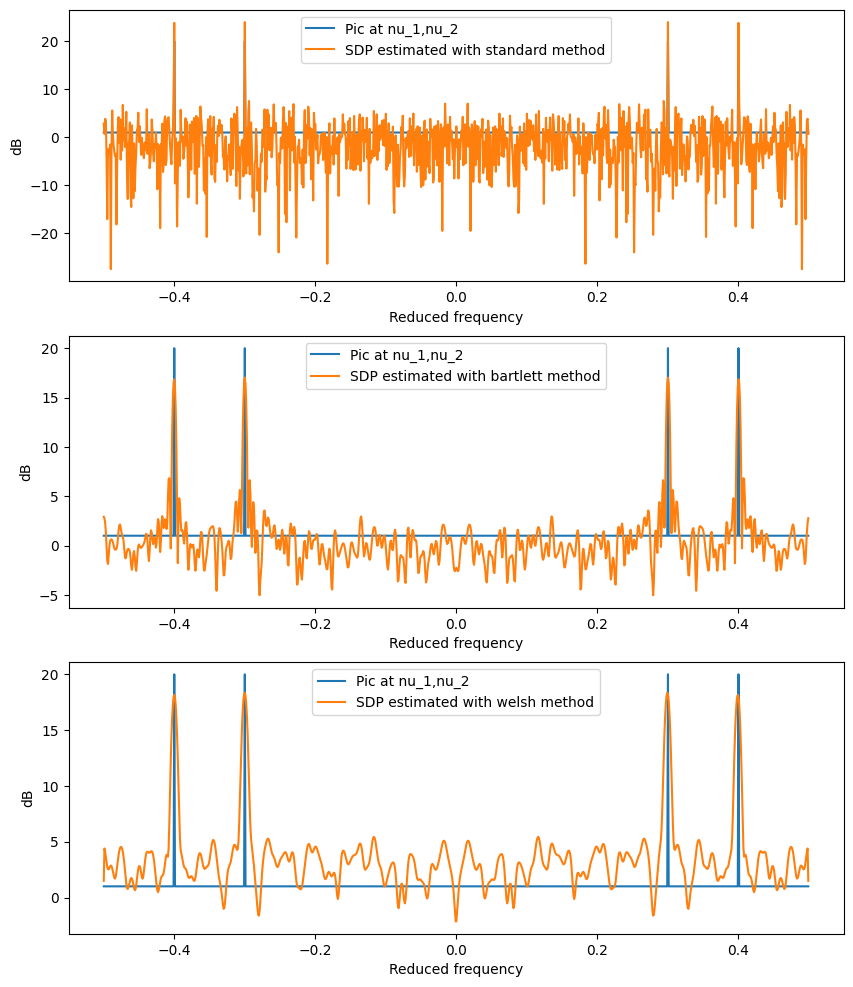

In [28]:
#2.2
freq=[0.4,0.3]
amp=[1,1]
phase=[0,0]
sigma=1
sig=sig_sin(freq,amp,phase,sigma,N)   #Generation of the signal
def close(v,N):
    for x in freq:
        if np.abs(x-np.abs(v))<1/N:
            return True
    else :
        return False
pic=np.array([20*sigma**2 if close(v,N) else sigma**2 for v in nu])

plt.figure(figsize=(10, 12))
plt.subplot(3,1,1)
plt.plot(nu,pic) 
plt.plot(nu,periodOgram(sig,S_len,toggle=False))
plt.legend(['Pic at nu_1,nu_2','SDP estimated with standard method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.subplot(3,1,2)
plt.plot(nu,pic)
plt.plot(nu,periodOgram(sig,S_len,method='bartlett',L=10,toggle=False))
plt.legend(['Pic at nu_1,nu_2','SDP estimated with bartlett method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.subplot(3,1,3)
plt.plot(nu,pic )
plt.plot(nu,periodOgram(sig,S_len,method='welsh',L=10,overlap=50,toggle=False))
plt.legend(['Pic at nu_1,nu_2','SDP estimated with welsh method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.show()


plt.show()

If $\Delta \nu < \frac 2 N $ then we can't distinguish $\nu _1$ from $\nu _2$ in the periodogram

[ 1.          0.08534169  0.22437511 -0.23057906 -0.08074771]


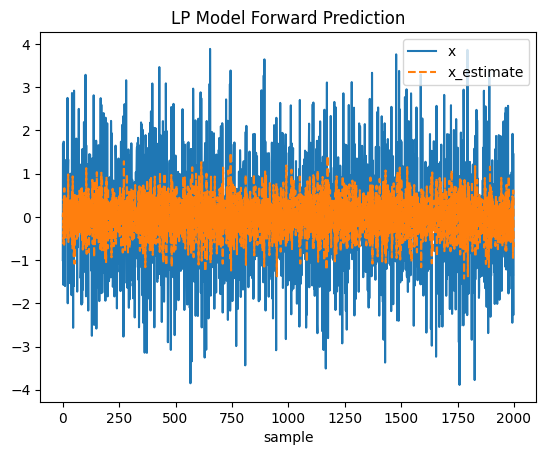

In [29]:
#2.4,2.5
#You may want to change these parameters
freq=[0.5,0.3]
amp=[1,1]
phase=[0,0]
sigma=1

sig_sin_est=estimate(sig_sin(freq,amp,phase,sigma,N),order=4)

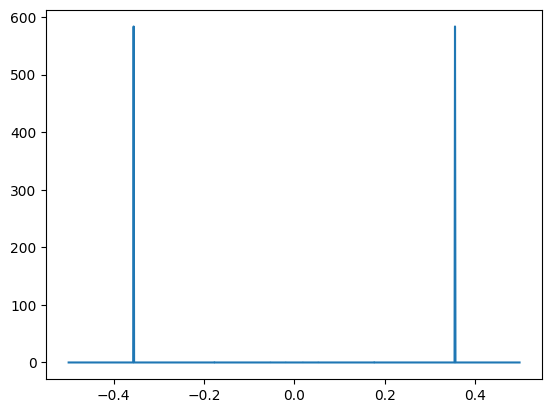

In [30]:
#2.6
def e(nu,N):
    ''' Compute an array of complex exponential used in Capon approximation'''
    return np.array([np.exp(-2j*np.pi*nu*k) for k in range(N)])

def capon(x,S_len):     #We suppose XX^H to be symmetric positive definite
    ''' Compute a periodogram according to Capon formula'''
    R_XX=np.array([[x1*x2 for x1 in x] for x2 in x])
    return 1/np.real([np.conjugate(e(j/S_len,N))@R_XX@np.transpose(e(j/S_len,N)) for j in range(S_len)])

#Really slow (took about 30 seconds)
plt.plot(nu,np.fft.fftshift(capon(sig,S_len)))


$$3. ~~Autoregressive~~moving~~average ~~process$$

In [31]:
#3.1
def init_ARMA(sigma,ar_coeff,ma_coeff,N):
    ''' Initiate an ARMA(p,q) process using recursive formula'''
    Z=X=np.random.normal(scale=sigma,size=N)
    X=np.zeros(N)
    for t in range(len(ar_coeff),N):
        X[t]+=ar_coeff@np.transpose([X[t-i] for i in range(1,len(ar_coeff)+1)])+ma_coeff@np.transpose([X[t-i] for i in range(1,len(ma_coeff)+1)])+Z[t]
    return X

N = 1000  
AR_coeffs = [-0.5, 0.2]  
MA_coeffs = [0.7, -0.4]  
sigma = 1  
x=init_ARMA(sigma,AR_coeffs,MA_coeffs,N)

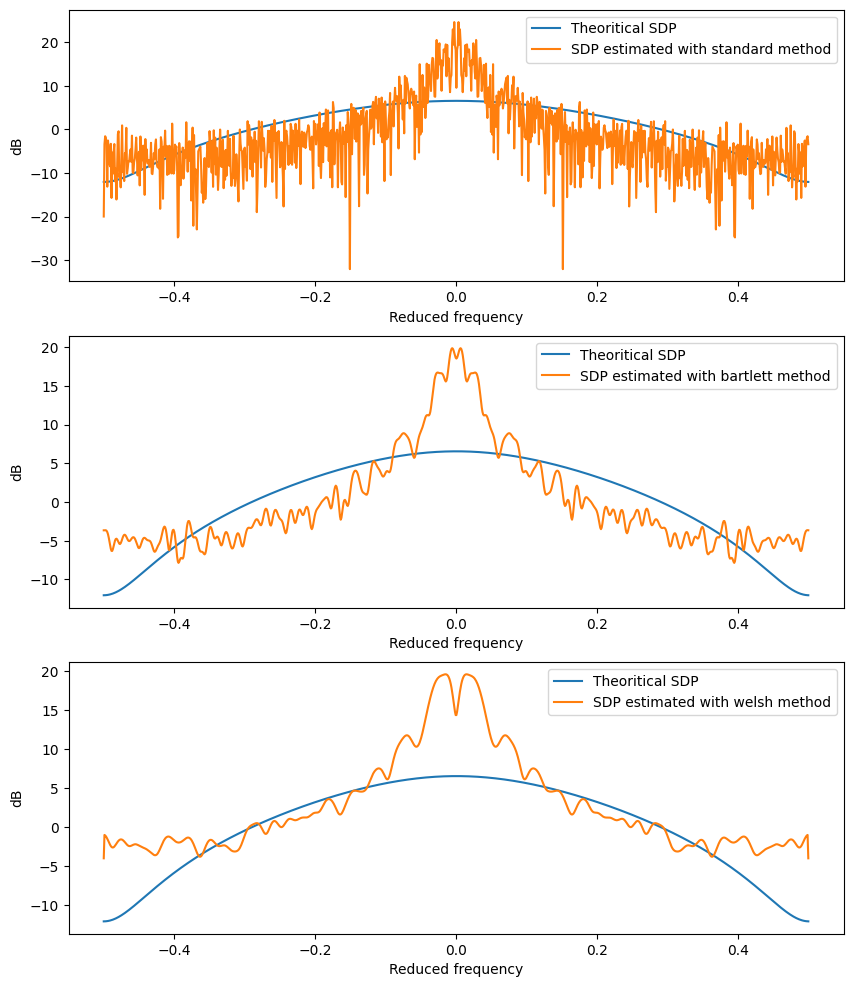

In [35]:
N = 1000  
AR_coeffs = [0.2]  
MA_coeffs = [0.7]  
sigma = 1  
x=init_ARMA(sigma,AR_coeffs,MA_coeffs,N)

#Displaying periodogram
S_len=1000
nu=[i/S_len-1/2 for i in range(S_len)]
S_th=10*np.log10([np.abs(1+MA_coeffs[0]*np.exp(2j*np.pi*v))**2*sigma**2/np.abs(1-AR_coeffs[0]*np.exp(2j*np.pi*v))**2 for v in nu])
plt.figure(figsize=(10, 12))
plt.subplot(3,1,1)
plt.plot(nu,S_th) 
plt.plot(nu,periodOgram(x,S_len,toggle=False))
plt.legend(['Theoritical SDP','SDP estimated with standard method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.subplot(3,1,2)
plt.plot(nu,S_th)
plt.plot(nu,periodOgram(x,S_len,method='bartlett',L=10,toggle=False))
plt.legend(['Theoritical SDP','SDP estimated with bartlett method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.subplot(3,1,3)
plt.plot(nu,S_th )
plt.plot(nu,periodOgram(x,S_len,method='welsh',L=10,overlap=50,toggle=False))
plt.legend(['Theoritical SDP','SDP estimated with welsh method'])
plt.xlabel('Reduced frequency')
plt.ylabel('dB')
plt.show()

#The estimation of SDP seems quite bad here

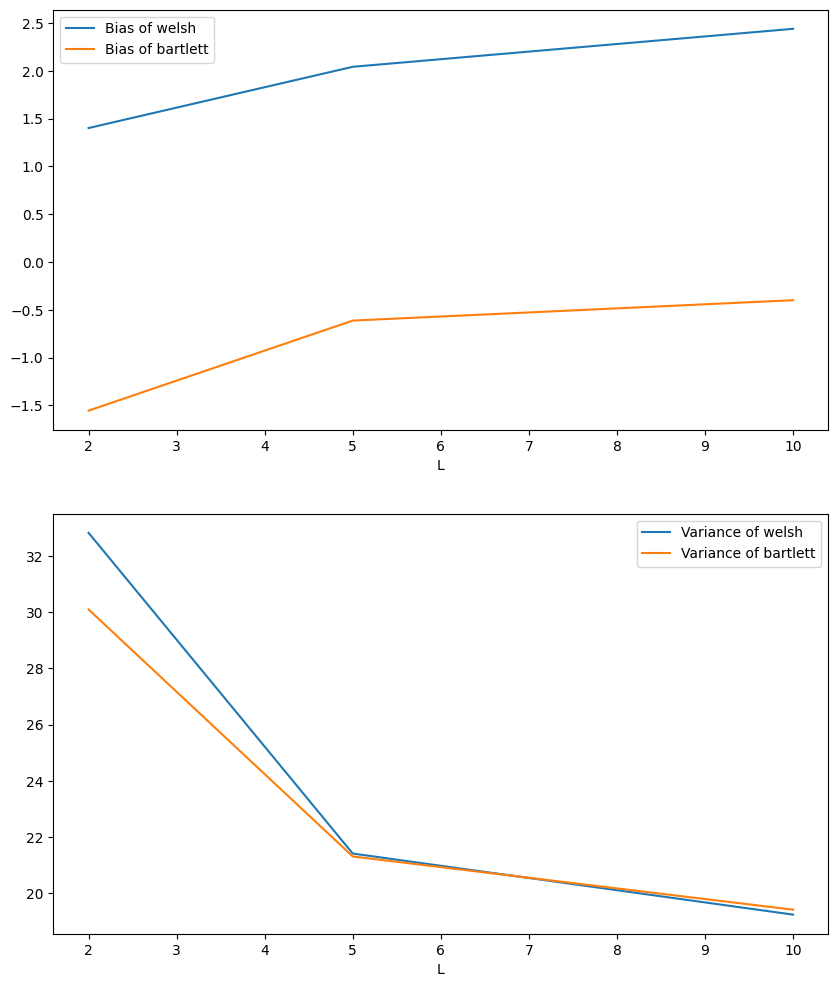

In [33]:
#3.3
S_th=10*np.log10([np.abs(1+MA_coeffs[0]*np.exp(2j*np.pi*v))**2*sigma**2/np.abs(1-AR_coeffs[0]*np.exp(2j*np.pi*v))**2 for v in nu])
bias= {'welsh': [], 'bartlett': []}
variance= {'welsh': [], 'bartlett': []}
L_value=[2,5,10]
for L in L_value:
    for method in ['welsh','bartlett']:
        P=periodOgram(x,S_len,method=method,L=L,overlap=S_len//(L*3),toggle=False)
        bias[method].append(np.mean(P-S_th))
        variance[method].append(np.var(P-S_th))
plt.figure(figsize=(10, 12))
plt.subplot(2,1,1)
plt.plot(L_value,bias['welsh'])
plt.plot(L_value,bias['bartlett'])
plt.legend(['Bias of welsh','Bias of bartlett'])
plt.xlabel('L value')
plt.subplot(2,1,2)
plt.plot(L_value,variance['welsh'])
plt.plot(L_value,variance['bartlett'])
plt.legend(['Variance of welsh','Variance of bartlett'])
plt.xlabel('L value')
plt.show()
